In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from matplotlib.pyplot import rc_context
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=100, dpi_save=1000)
sc.logging.print_header()

2023-05-21 12:16:22.103047: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/R/lib:/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-8-openjdk-amd64/jre/lib/amd64/server
2023-05-21 12:16:22.103108: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.21.1 scipy==1.8.1 pandas==1.3.1 scikit-learn==0.24.2 statsmodels==0.13.2 python-igraph==0.9.6 pynndescent==0.5.4


In [3]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [4]:
root_path = '/lustre/scratch126/cellgen/team298/hg6/Fetal_skin/data/final/'
save_path = '/home/jovyan/projects/skin/fetal_skin/'
sc.settings.figdir = save_path + 'figures/other plots/'

# Load prenatal skin dataset data object

In [5]:
#load data object: prenatal skin only, post qc

fskin_object = 'fetal_skin.norm.maternal_removed.20220202.h5ad'
fskin_path = root_path + fskin_object
adata = sc.read(fskin_path)

Only considering the two last: ['.20220202', '.h5ad'].
Only considering the two last: ['.20220202', '.h5ad'].


In [6]:
print(list(adata.obs['joint_annotation_20220202'].unique()))

['LYVE1++ macrophage', 'Monocyte (activated/differentiating)', 'Eo/baso/mast cell progenitor', 'DC2', 'TREM2+ macrophage', 'Monocyte precursor', 'Monocyte', 'WNT2+ fibroblast', 'Iron-recycling macrophage', 'NK cell', 'B cell', 'LTi', 'ILC3', 'Inflammatory DC', 'MEMP - Early erythroid', 'CD4 T cell', 'Pro B cell', 'HSC', 'Pre B cell', 'MHCII+ macrophage', 'LE', 'Pre pro B cell', 'Innate T type1', 'CD8 T cell', 'Myocytes', 'pDC', 'Mast cell (most mature)', 'DC1', 'Mast cell (medium)', 'Capillaries', 'Neutrophil2', 'Capillary arterioles', 'LC', 'Megakaryocyte', 'MEMP - Megak', 'Mast cell (earliest)', 'Erythroid (fetal)', 'Myoblasts', 'Myofibroblasts', 'Pre-dermal condensate', 'HOXC5+ early fibroblast', 'PEAR1+ fibroblast', 'Pericytes', 'FRZB+ early fibroblast', 'Early erythroid (embryonic)', 'Early myocytes', 'Neuron progenitors', 'Myelinating Schwann cells', 'Schwann/Schwann precursors', 'LMCD1+ mural cell', 'PLN+ mural cell', 'ILC2', 'Lymphoid progenitor', 'SPP1+ proliferating neuron pr

# Comparison of WNT2+ fibroblasts early vs late determined from Milo analysis

## Create milo object

In [7]:
#load csv (from R Milo output) - contains additional metadata column of 'Enrichment' early or late
milo_all = pd.read_csv('/home/jovyan/projects/skin/fetal_skin/milo csv/milo_cells_allnew.csv')
milo_all

,Unnamed: 0,sanger_id,chemistry,donor,gender,pcw,sorting,sample,chemistry_sorting,cell_caller,...,independent_annotation_broad2,independent_annotation_broad3,independent_annotation_broad4,independent_annotation_broad5,joint_annotation,is_maternal,fig1b_annotation,X_scvi_batch,X_scvi_labels,Enrichment
0,AAAGTAGCAGATCGGA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,...,Granulocyte progenitor,Granulocyte progenitor,Other blood cells,Immune,Eo/baso/mast cell progenitor,False,Haem progenitors,0,0,Early
1,AACACGTAGAGAGCTC-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,...,cDC,DC,Antigen Presenting Cells,Immune,DC2,False,cDC,0,0,Early
2,AACCATGGTGCCTTGG-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,...,Macrophage,Macrophage,Antigen Presenting Cells,Immune,Macrophage1,False,Macrophage,0,0,Early
3,AACTCAGCAGGACGTA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,...,Microglia,Microglia,Antigen Presenting Cells,Immune,Microglia,False,Macrophage,0,0,Early
4,AACTCAGGTCAGCTAT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,...,Macrophage,Macrophage,Antigen Presenting Cells,Immune,Macrophage1,False,Macrophage,0,0,Early
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104173,TTTGTCAAGTGAACGC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,...,Pericyte,Pericyte,Muscle,Stroma,Pericytes,False,Mural cell,14,0,Late
104174,TTTGTCAGTGCGAAAC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,...,Pericyte,Pericyte,Muscle,Stroma,Pericytes,False,Mural cell,14,0,Late
104175,TTTGTCATCCATGAGT-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,...,Erythroid,Erythroid,Erythroid,Erythroid,Early erythroid,False,Erythroid,14,0,Late
104176,TTTGTCATCGCAAGCC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,...,Lymphatic endothelium,Lymphatic endothelium,Endothelium,Stroma,LE,False,Lymphatic endothelium,14,0,Late


In [8]:
milo_all.rename(columns={'Unnamed: 0': 'index'}, inplace=True)
milo_all.set_index('index', inplace=True)
milo_all

,sanger_id,chemistry,donor,gender,pcw,sorting,sample,chemistry_sorting,cell_caller,scrublet_score,...,independent_annotation_broad2,independent_annotation_broad3,independent_annotation_broad4,independent_annotation_broad5,joint_annotation,is_maternal,fig1b_annotation,X_scvi_batch,X_scvi_labels,Enrichment
index,,,,,,,,,,,,,,,,,,,,,
AAAGTAGCAGATCGGA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.164557,...,Granulocyte progenitor,Granulocyte progenitor,Other blood cells,Immune,Eo/baso/mast cell progenitor,False,Haem progenitors,0,0,Early
AACACGTAGAGAGCTC-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.333333,...,cDC,DC,Antigen Presenting Cells,Immune,DC2,False,cDC,0,0,Early
AACCATGGTGCCTTGG-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.201970,...,Macrophage,Macrophage,Antigen Presenting Cells,Immune,Macrophage1,False,Macrophage,0,0,Early
AACTCAGCAGGACGTA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.105590,...,Microglia,Microglia,Antigen Presenting Cells,Immune,Microglia,False,Macrophage,0,0,Early
AACTCAGGTCAGCTAT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.389831,...,Macrophage,Macrophage,Antigen Presenting Cells,Immune,Macrophage1,False,Macrophage,0,0,Early
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGTGAACGC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.085938,...,Pericyte,Pericyte,Muscle,Stroma,Pericytes,False,Mural cell,14,0,Late
TTTGTCAGTGCGAAAC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.125778,...,Pericyte,Pericyte,Muscle,Stroma,Pericytes,False,Mural cell,14,0,Late
TTTGTCATCCATGAGT-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.034700,...,Erythroid,Erythroid,Erythroid,Erythroid,Early erythroid,False,Erythroid,14,0,Late


In [9]:
len(list(milo_all.index))

104178

In [10]:
adata_milo = adata[:]
adata_milo

View of AnnData object with n_obs × n_vars = 186533 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_2022

In [11]:
adata_milo.obs['Enrichment'] = milo_all['Enrichment']
adata_milo.obs['Enrichment'] = adata_milo.obs['Enrichment'].fillna('Mixed')

Trying to set attribute `.obs` of view, copying.


In [12]:
adata_milo.obs['Enrichment'].value_counts()

Mixed    82355
Late     64183
Early    39995
Name: Enrichment, dtype: int64

In [13]:
adata_milo.obs['early_late_pcw'] = adata_milo.obs['Enrichment'].astype(str) + '_' + adata_milo.obs['pcw'].astype(str)

In [14]:
adata_milo.obs['early_late_celltype'] = adata_milo.obs['Enrichment'].astype(str) + '_' + adata_milo.obs['independent_annotation_refined_20220202'].astype(str)

In [15]:
adata_milo.obs

,sanger_id,chemistry,donor,gender,pcw,sorting,sample,chemistry_sorting,cell_caller,scrublet_score,...,joint_annotation_20220201a,joint_annotation_20220201b,fig1b_annotation_20220201,fig1b_annotation_20220202,joint_annotation_20220202,fig1b_annotation_v2,independent_annotation_refined_20220202,Enrichment,early_late_pcw,early_late_celltype
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGGTCAGTGGA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.225806,...,Macrophage1,Macrophage,Macrophage,Macrophage,LYVE1++ macrophage,Macrophage,LYVE1++ macrophage,Mixed,Mixed_8,Mixed_LYVE1++ macrophage
AAAGATGGTCGATTGT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.149606,...,Monocyte (activated/differentiating),Monocyte (activated/differentiating),Monocyte,Monocyte,Monocyte (activated/differentiating),Monocyte,Monocyte (activated/differentiating),Late,Late_8,Late_Monocyte (activated/differentiating)
AAAGCAAAGATGTGGC-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.201970,...,Macrophage1,Macrophage,Macrophage,Macrophage,LYVE1++ macrophage,Macrophage,LYVE1++ macrophage,Mixed,Mixed_8,Mixed_LYVE1++ macrophage
AAAGTAGCAGATCGGA-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.164557,...,Eo/baso/mast cell progenitor,Eo/baso/mast cell progenitor,Progenitor,Progenitor,Eo/baso/mast cell progenitor,Haem progenitor,Eo/baso/mast cell progenitor,Early,Early_8,Early_Eo/baso/mast cell progenitor
AAAGTAGTCCGCATCT-1-4834STDY7002879,4834STDY7002879,SC3Pv2,F16,male,8,CD45P,F16_male_8+1PCW,SC3Pv2_CD45P,Both,0.181818,...,Macrophage1,Macrophage,Macrophage,Macrophage,LYVE1++ macrophage,Macrophage,LYVE1++ macrophage,Mixed,Mixed_8,Mixed_LYVE1++ macrophage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGTGAACGC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.085937,...,Pericytes,Pericytes,Mural cell,Mural cell,Pericytes,Mural cell,Pericytes,Late,Late_14,Late_Pericytes
TTTGTCAGTGCGAAAC-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.125778,...,Pericytes,Pericytes,Mural cell,Mural cell,Pericytes,Mural cell,Pericytes,Late,Late_14,Late_Pericytes
TTTGTCATCCATGAGT-1-FCAImmP7964510,FCAImmP7964510,SC5P-R2,F71,female,14,CD45en,F71-GEX_5_SKI_45en,SC5P-R2_CD45en,Both,0.034700,...,Early erythroid,Early erythroid,Erythroid,Erythroid,Early erythroid,Erythroid,Early erythroid,Late,Late_14,Late_Early erythroid


In [28]:
#adata_milo.write_h5ad(root_path +'milo_enrichment.h5ad')

## Subset to early and late WNT2+ fibroblasts

In [29]:
# load adata_milo created above

In [16]:
adata_milo

AnnData object with n_obs × n_vars = 186533 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220202', '

In [17]:
print(list(adata_milo.obs['independent_annotation_refined_20220202'].unique()))

['LYVE1++ macrophage', 'Monocyte (activated/differentiating)', 'Eo/baso/mast cell progenitor', 'DC2', 'TREM2+ macrophage', 'Monocyte precursor', 'Monocyte', 'WNT2+ fibroblast', 'Iron-recycling macrophage', 'NK cell', 'B cell', 'LTi cell', 'ILC3', 'Inflammatory DC', 'MEMP - Early erythroid', 'CD4 T cell', 'Pro B cell', 'HSC', 'Pre B cell', 'MHCII+ macrophage', 'LE', 'Pre pro B cell', 'Innate T type1', 'CD8 T cell', 'Myocytes', 'pDC', 'Mast cell (most mature)', 'DC1', 'Mast cell (medium)', 'Capillaries', 'Neutrophil2', 'Capillary arterioles', 'LC', 'Megakaryocyte', 'MEMP - Megak', 'Mast cell (earliest)', 'Erythroid (fetal)', 'Myoblasts', 'Myofibroblasts', 'Pre-dermal condensate', 'HOXC5+ early fibroblast', 'PEAR1+ fibroblast', 'Pericytes', 'FRZB+ early fibroblast', 'Early erythroid (embryonic)', 'Early myocytes', 'Neuron progenitors', 'Myelinating Schwann cells', 'Schwann/Schwann precursors', 'LMCD1+ mural cell', 'PLN+ mural cell', 'ILC2', 'Lymphoid progenitor', 'SPP1+ proliferating neur

In [18]:
print(list(adata_milo.obs['Enrichment'].unique()))

['Mixed', 'Late', 'Early']


In [19]:
cells_keepfib = ['WNT2+ fibroblast']
adata_milo_WNT2fib = adata_milo[adata_milo.obs['independent_annotation_refined_20220202'].isin(cells_keepfib)]

In [20]:
enrichment_keep = ['Late','Early']
adata_milo_WNT2fib = adata_milo_WNT2fib[adata_milo_WNT2fib.obs['Enrichment'].isin(enrichment_keep)]
adata_milo_WNT2fib

View of AnnData object with n_obs × n_vars = 16144 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220

In [21]:
#only keep genes present in about >10% cells (see method in Suo, Dann et al)
sc.pp.filter_genes(adata_milo_WNT2fib, min_cells=150)

filtered out 15646 genes that are detected in less than 150 cells


Trying to set attribute `.var` of view, copying.


In [22]:
#compute DEGs between early and late WNT2+ fibroblast
sc.pp.highly_variable_genes(adata_milo_WNT2fib)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [23]:
adata_milo_WNT2fib

AnnData object with n_obs × n_vars = 16144 × 13239
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220202', 'E

In [24]:
sc.tl.rank_genes_groups(adata_milo_WNT2fib, groupby='Enrichment', key_added='rank_genes_groups_MiloFib', method = 'wilcoxon')

ranking genes


/home/jovyan/my-conda-envs/my_new_env_clone2/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Enrichment' as categorical
/home/jovyan/my-conda-envs/my_new_env_clone2/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'early_late_pcw' as categorical
/home/jovyan/my-conda-envs/my_new_env_clone2/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reord

    finished: added to `.uns['rank_genes_groups_MiloFib']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:30)


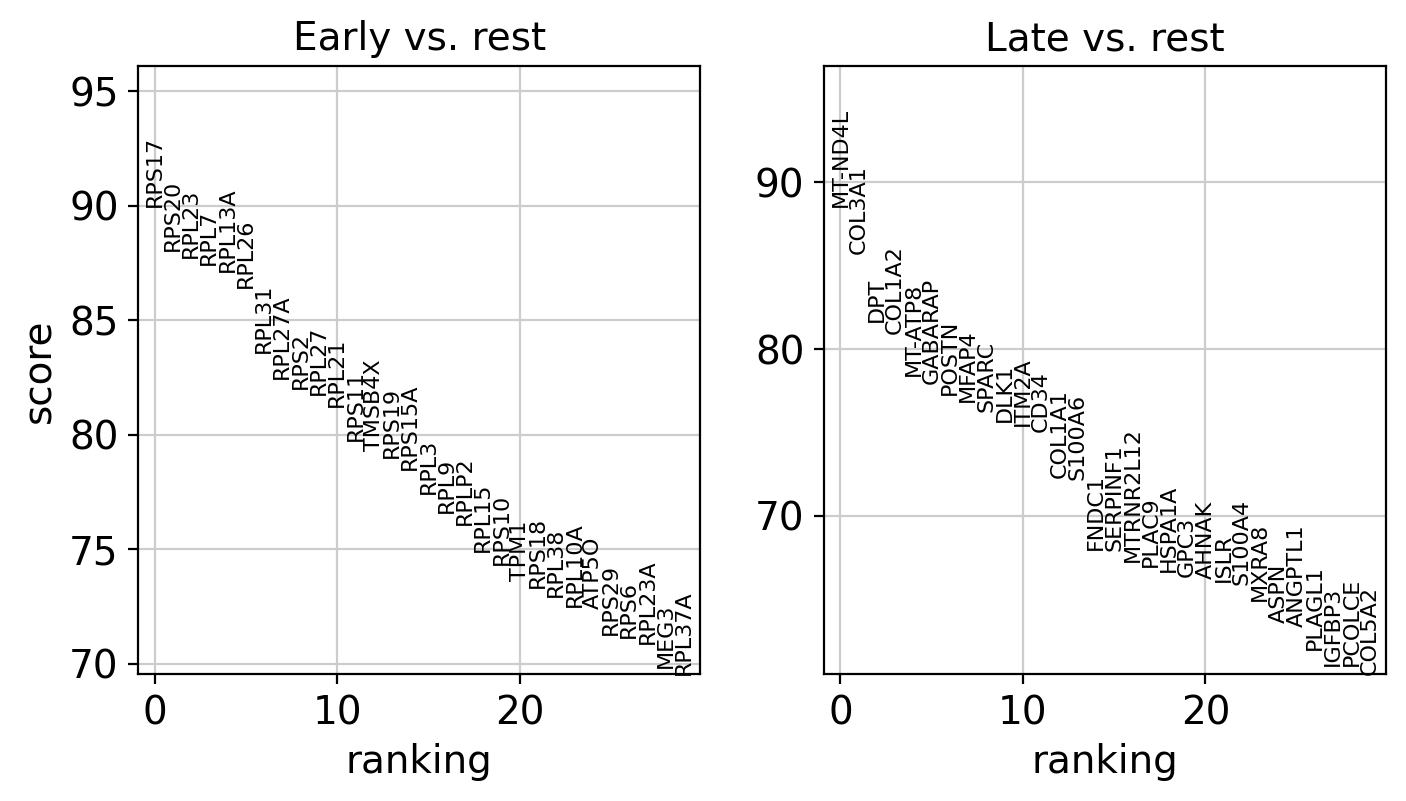

In [25]:
sc.pl.rank_genes_groups(adata_milo_WNT2fib, n_genes=30, sharey=False, key='rank_genes_groups_MiloFib')

In [26]:
#get list of significant genes for early and late WNT2+ fibroblast to be used in GSEApy analysis
genes_WNT2fib_Early = sc.get.rank_genes_groups_df(adata_milo_WNT2fib, group='Early', key='rank_genes_groups_MiloFib', log2fc_min=1.00, 
                                    pval_cutoff=0.01)[['names', 'pvals', 'logfoldchanges', 'scores']]

genes_WNT2fib_Late = sc.get.rank_genes_groups_df(adata_milo_WNT2fib, group='Late', key='rank_genes_groups_MiloFib', log2fc_min=1.00, 
                                    pval_cutoff=0.01)[['names', 'pvals', 'logfoldchanges', 'scores']]

In [21]:
#save genes list as csv
genes_WNT2fib_Early.to_csv('/home/jovyan/projects/skin/fetal_skin/GSEA_milo/15042022/WNT2fib_early/WNT2fib_early_logfc1p001_12072022.csv')
genes_WNT2fib_Late.to_csv('/home/jovyan/projects/skin/fetal_skin/GSEA_milo/15042022/WNT2fib_late/WNT2fib_late_logfc1p001_12072022.csv')

In [27]:
glist_WNT2fib_Early = genes_WNT2fib_Early['names'].squeeze().str.strip().tolist()
print(len(glist_WNT2fib_Early))

1128


In [28]:
glist_WNT2fib_Late = genes_WNT2fib_Late['names'].squeeze().str.strip().tolist()
print(len(glist_WNT2fib_Late))

706


## GSEApy analysis

In [29]:
import gseapy as gp

In [30]:
from gseapy.plot import barplot, dotplot

In [31]:
enr_WNT2fibearly = gp.enrichr(gene_list=glist_WNT2fib_Early,
                 gene_sets='GO_Biological_Process_2021',
                 organism='Human',
                 #description='gseaWNT2fibearly',
                 outdir='/home/jovyan/projects/skin/fetal_skin/GSEA_milo/21052023/WNT2fib_early',
                 no_plot=True,
                 cutoff=0.05)

In [32]:
enr_WNT2fibearly_Hallmark = gp.enrichr(gene_list=glist_WNT2fib_Early,
                 gene_sets='MSigDB_Hallmark_2020',
                 organism='Human',
                 #description='gseaWNT2fibearly',
                 outdir='/home/jovyan/projects/skin/fetal_skin/GSEA_milo/21052023/WNT2fib_early',
                 no_plot=True,
                 cutoff=0.05)

In [33]:
enr_WNT2fiblate = gp.enrichr(gene_list=glist_WNT2fib_Late,
                 gene_sets='GO_Biological_Process_2021',
                 organism='Human',
                 #description='gseaWNT2fiblate',
                 outdir='/home/jovyan/projects/skin/fetal_skin/GSEA_milo/21052023/WNT2fib_late',
                 no_plot=True,
                 cutoff=0.05)

In [34]:
enr_WNT2fiblate_Hallmark = gp.enrichr(gene_list=glist_WNT2fib_Late,
                 gene_sets='MSigDB_Hallmark_2020',
                 organism='Human',
                 #description='gseaWNT2fiblate',
                 outdir='/home/jovyan/projects/skin/fetal_skin/GSEA_milo/21052023/WNT2fib_late',
                 no_plot=True,
                 cutoff=0.05)

In [35]:
enr_WNT2fibearly.results.head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,nervous system development (GO:0007399),57/447,6.895242e-09,0.000027,0,0,2.522143,47.397210,SEMA5A;ACHE;SH3GL3;AVIL;SLC2A1;CXCL1;HAPLN3;HA...
1,GO_Biological_Process_2021,cellular response to cytokine stimulus (GO:007...,55/482,5.295614e-07,0.001045,0,0,2.214184,31.997656,CDKN1A;IL1RN;CD40;NDUFA13;CXCL8;F13A1;SLA;CXCL...
2,GO_Biological_Process_2021,negative regulation of transcription by RNA po...,69/684,1.971814e-06,0.002310,0,0,1.934227,25.409082,TENM2;SPI1;PRDM6;ZBTB21;UBE2D1;TNF;IRF2BPL;ZFP...
3,GO_Biological_Process_2021,positive regulation of macromolecule metabolic...,45/384,2.789328e-06,0.002310,0,0,2.271591,29.052986,CXCL8;TFRC;LEF1;PIK3R3;TWIST1;ETS1;TNF;ACTG2;H...
4,GO_Biological_Process_2021,negative regulation of Wnt signaling pathway (...,28/191,3.320074e-06,0.002310,0,0,2.921651,36.858155,HDAC1;JADE1;APCDD1;MLLT3;NKD1;NKD2;MDK;FRZB;WI...
5,GO_Biological_Process_2021,nuclear-transcribed mRNA catabolic process (GO...,26/171,3.722009e-06,0.002310,0,0,3.047137,38.093011,DDX5;RPL31;RPL36A;RPL7;HELZ2;PPP2CA;EXOSC6;RPS...
6,GO_Biological_Process_2021,cotranslational protein targeting to membrane ...,18/94,4.428307e-06,0.002310,0,0,4.010526,49.439736,SRP19;ARL6IP1;RPL21;RPL31;RPL23;RPL36A;RPL13A;...
7,GO_Biological_Process_2021,"negative regulation of transcription, DNA-temp...",87/948,4.684120e-06,0.002310,0,0,1.748249,21.453340,TENM2;NDUFA13;SPI1;PRDM6;ZBTB21;UBE2D1;TNF;IKZ...
8,GO_Biological_Process_2021,positive regulation of cell population prolife...,51/474,7.429732e-06,0.003257,0,0,2.065318,24.391449,CDKN1A;BNC1;IRS2;AREG;TNF;AQP1;HMGN5;MDK;MYC;N...
9,GO_Biological_Process_2021,SRP-dependent cotranslational protein targetin...,17/90,9.818622e-06,0.003570,0,0,3.940458,45.438332,SRP19;RPL21;RPL31;RPL23;RPL36A;RPL13A;RPL7;RPS...


In [36]:
enr_WNT2fibearly_Hallmark.results.head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,74/200,4.466601e-41,2.233301e-39,0,0,10.445499,970.484604,BTG2;CDKN1A;TNFAIP8;TNFAIP3;IRS2;CXCL1;CXCL3;A...
1,MSigDB_Hallmark_2020,Hypoxia,37/200,1.370704e-10,3.426761e-09,0,0,3.892601,88.403028,ERRFI1;CDKN1A;PFKFB3;SDC4;HEXA;SLC2A1;NEDD4L;C...
2,MSigDB_Hallmark_2020,Epithelial Mesenchymal Transition,35/200,2.024709e-09,3.374516e-08,0,0,3.630514,72.675042,TAGLN;NNMT;CXCL8;SDC4;COL11A1;TNFAIP3;PLOD2;CX...
3,MSigDB_Hallmark_2020,UV Response Up,26/158,8.087886e-07,1.010986e-05,0,0,3.349557,46.986679,BTG2;TFRC;AMD1;CTSV;CXCL2;ICAM1;HTR7;HYAL2;HMO...
4,MSigDB_Hallmark_2020,IL-6/JAK/STAT3 Signaling,17/87,6.099362e-06,6.099362e-05,0,0,4.109991,49.350003,JUN;TNFRSF12A;ITGA4;CXCL1;CXCL3;TNF;SOCS3;IL6;...
5,MSigDB_Hallmark_2020,Apoptosis,24/161,1.224049e-05,1.020041e-04,0,0,2.972866,33.625375,JUN;TGFB2;CDKN1A;BTG2;EGR3;GADD45B;TNFRSF12A;G...
6,MSigDB_Hallmark_2020,KRAS Signaling Up,27/200,2.293180e-05,1.637986e-04,0,0,2.650628,28.316618,SNAP25;SPON1;CXCR4;F13A1;TNFAIP3;PLAT;GLRX;RET...
7,MSigDB_Hallmark_2020,Estrogen Response Early,26/200,6.181463e-05,3.434146e-04,0,0,2.535348,24.571001,SLC2A1;AREG;TOB1;CALB2;CCND1;MYC;RPS6KA2;LRIG1...
8,MSigDB_Hallmark_2020,Estrogen Response Late,26/200,6.181463e-05,3.434146e-04,0,0,2.535348,24.571001,PTGER3;SNX10;AREG;TOB1;SCUBE2;ZFP36;CCND1;MDK;...
9,MSigDB_Hallmark_2020,Interferon Gamma Response,25/200,1.597448e-04,7.987240e-04,0,0,2.421578,21.169268,CD40;CDKN1A;TNFAIP3;PTGS2;IFI44L;ICAM1;HELZ2;S...


In [37]:
enr_WNT2fiblate.results.head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,extracellular matrix organization (GO:0030198),40/300,4.788212e-13,1.425508e-09,0,0,4.396858,124.727657,VIT;COL18A1;SPARC;ECM2;COL16A1;LAMA2;COL14A1;E...
1,GO_Biological_Process_2021,extracellular structure organization (GO:0043062),33/216,1.229619e-12,1.425508e-09,0,0,5.120722,140.432304,VIT;COL18A1;SPARC;ECM2;COL16A1;LAMA2;COL14A1;E...
2,GO_Biological_Process_2021,external encapsulating structure organization ...,33/217,1.402599e-12,1.425508e-09,0,0,5.092625,138.991470,VIT;COL18A1;SPARC;ECM2;COL16A1;LAMA2;COL14A1;E...
3,GO_Biological_Process_2021,collagen fibril organization (GO:0030199),15/89,4.789317e-07,3.650657e-04,0,0,5.638127,82.044381,COL18A1;CRTAP;COL16A1;COL14A1;COL12A1;LOXL4;DP...
4,GO_Biological_Process_2021,eye morphogenesis (GO:0048592),7/20,3.438635e-06,1.811204e-03,0,0,14.852757,186.854155,MFAP5;ALDH1A3;EFEMP1;COL5A1;COL5A2;MFAP2;FBN1
5,GO_Biological_Process_2021,regulation of cell migration (GO:0030334),34/408,3.564192e-06,1.811204e-03,0,0,2.559524,32.108133,ACVRL1;SEMA5B;SERPINE2;CSF1;PLXND1;SEMA3C;SEMA...
6,GO_Biological_Process_2021,positive regulation of cell population prolife...,36/474,1.474314e-05,6.421691e-03,0,0,2.313147,25.733137,PID1;CSF1;TCIRG1;LAMC1;GLI1;HOXC10;PTHLH;DPP4;...
7,GO_Biological_Process_2021,embryonic eye morphogenesis (GO:0048048),5/11,2.091421e-05,7.247514e-03,0,0,22.929149,247.063452,MFAP5;ALDH1A3;EFEMP1;MFAP2;FBN1
8,GO_Biological_Process_2021,regulation of cell population proliferation (G...,50/764,2.139312e-05,7.247514e-03,0,0,1.983415,21.326556,ACVRL1;COL18A1;CDKN1B;CSF1;ELN;TCIRG1;GLI1;HOX...
9,GO_Biological_Process_2021,hemopoiesis (GO:0030097),13/94,2.563835e-05,7.817132e-03,0,0,4.449593,47.038522,CEBPA;WNT10B;JAG1;FST;FLT3LG;ZFP36L2;TGFBR2;FS...


In [38]:
enr_WNT2fiblate_Hallmark.results.head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Epithelial Mesenchymal Transition,39/200,1.999084e-18,9.595601e-17,0,0,6.948579,283.181276,SPARC;ECM2;COL16A1;SERPINE2;LAMA2;ELN;COL12A1;...
1,MSigDB_Hallmark_2020,Coagulation,20/138,8.413908e-08,2.019338e-06,0,0,4.737856,77.183446,CFD;SPARC;ANXA1;GSN;CFH;C1S;F10;PROS1;MMP2;FN1...
2,MSigDB_Hallmark_2020,Myogenesis,22/200,2.490980e-06,3.985569e-05,0,0,3.454169,44.568572,CFD;PRNP;SPARC;GSN;LAMA2;GPX3;IGFBP3;FST;FHL1;...
3,MSigDB_Hallmark_2020,Apical Junction,19/200,9.108049e-05,1.092966e-03,0,0,2.920432,27.171022,COL16A1;VCAM1;NEGR1;MMP2;AMIGO2;NRXN2;THBS3;MA...
4,MSigDB_Hallmark_2020,UV Response Dn,15/144,1.785841e-04,1.714407e-03,0,0,3.225019,27.833371,CDKN1B;CITED2;NEK7;LAMC1;TFPI;TGFBR2;COL1A1;TG...
5,MSigDB_Hallmark_2020,Angiogenesis,7/36,2.263859e-04,1.811087e-03,0,0,6.652607,55.837125,POSTN;VCAN;COL3A1;JAG1;COL5A2;LPL;S100A4
6,MSigDB_Hallmark_2020,Apoptosis,14/161,1.741764e-03,1.084011e-02,0,0,2.635150,16.740731,RNASEL;GSTM1;CDKN1B;ANXA1;GSN;DIABLO;GPX3;MMP2...
7,MSigDB_Hallmark_2020,KRAS Signaling Up,16/200,2.021715e-03,1.084011e-02,0,0,2.408318,14.940743,CFH;CAB39L;TMEM176B;IGFBP3;TMEM176A;IGF2;TFPI;...
8,MSigDB_Hallmark_2020,Bile Acid Metabolism,11/112,2.032520e-03,1.084011e-02,0,0,3.007664,18.642944,SLC35B2;FADS2;SULT1B1;HSD3B7;AMACR;ABCA6;NEDD4...
9,MSigDB_Hallmark_2020,Hypoxia,15/200,5.031992e-03,2.415356e-02,0,0,2.242226,11.865726,SRPX;CDKN1B;CITED2;IGFBP3;ADM;ENO2;SELENBP1;CO...


<AxesSubplot:title={'center':'WNT2fib_late_GOBP_2021'}, xlabel='-log$_{10}$(Adjusted P-value)'>

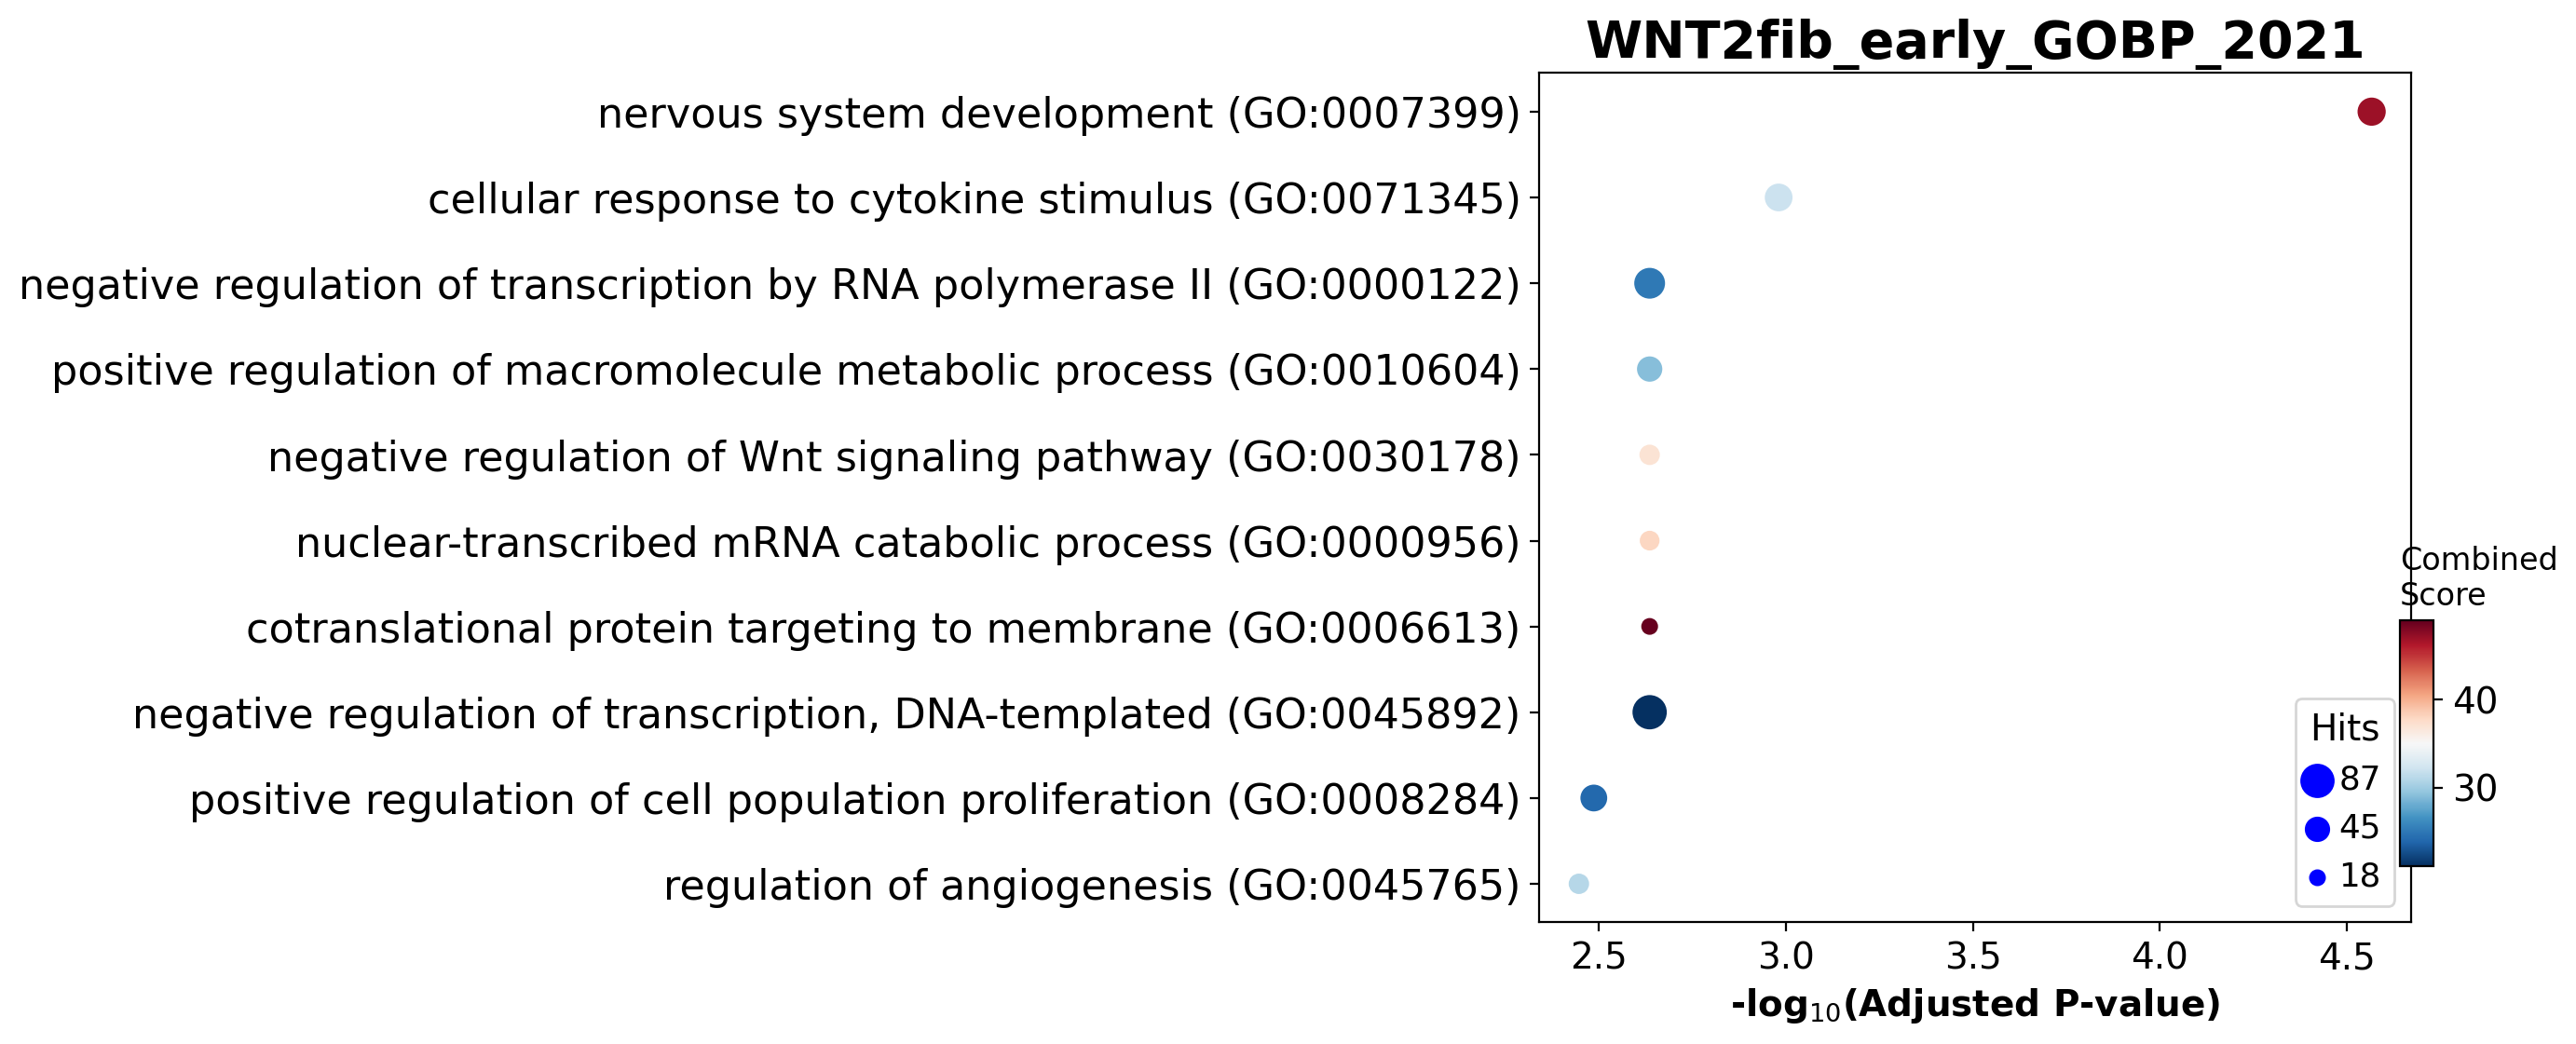

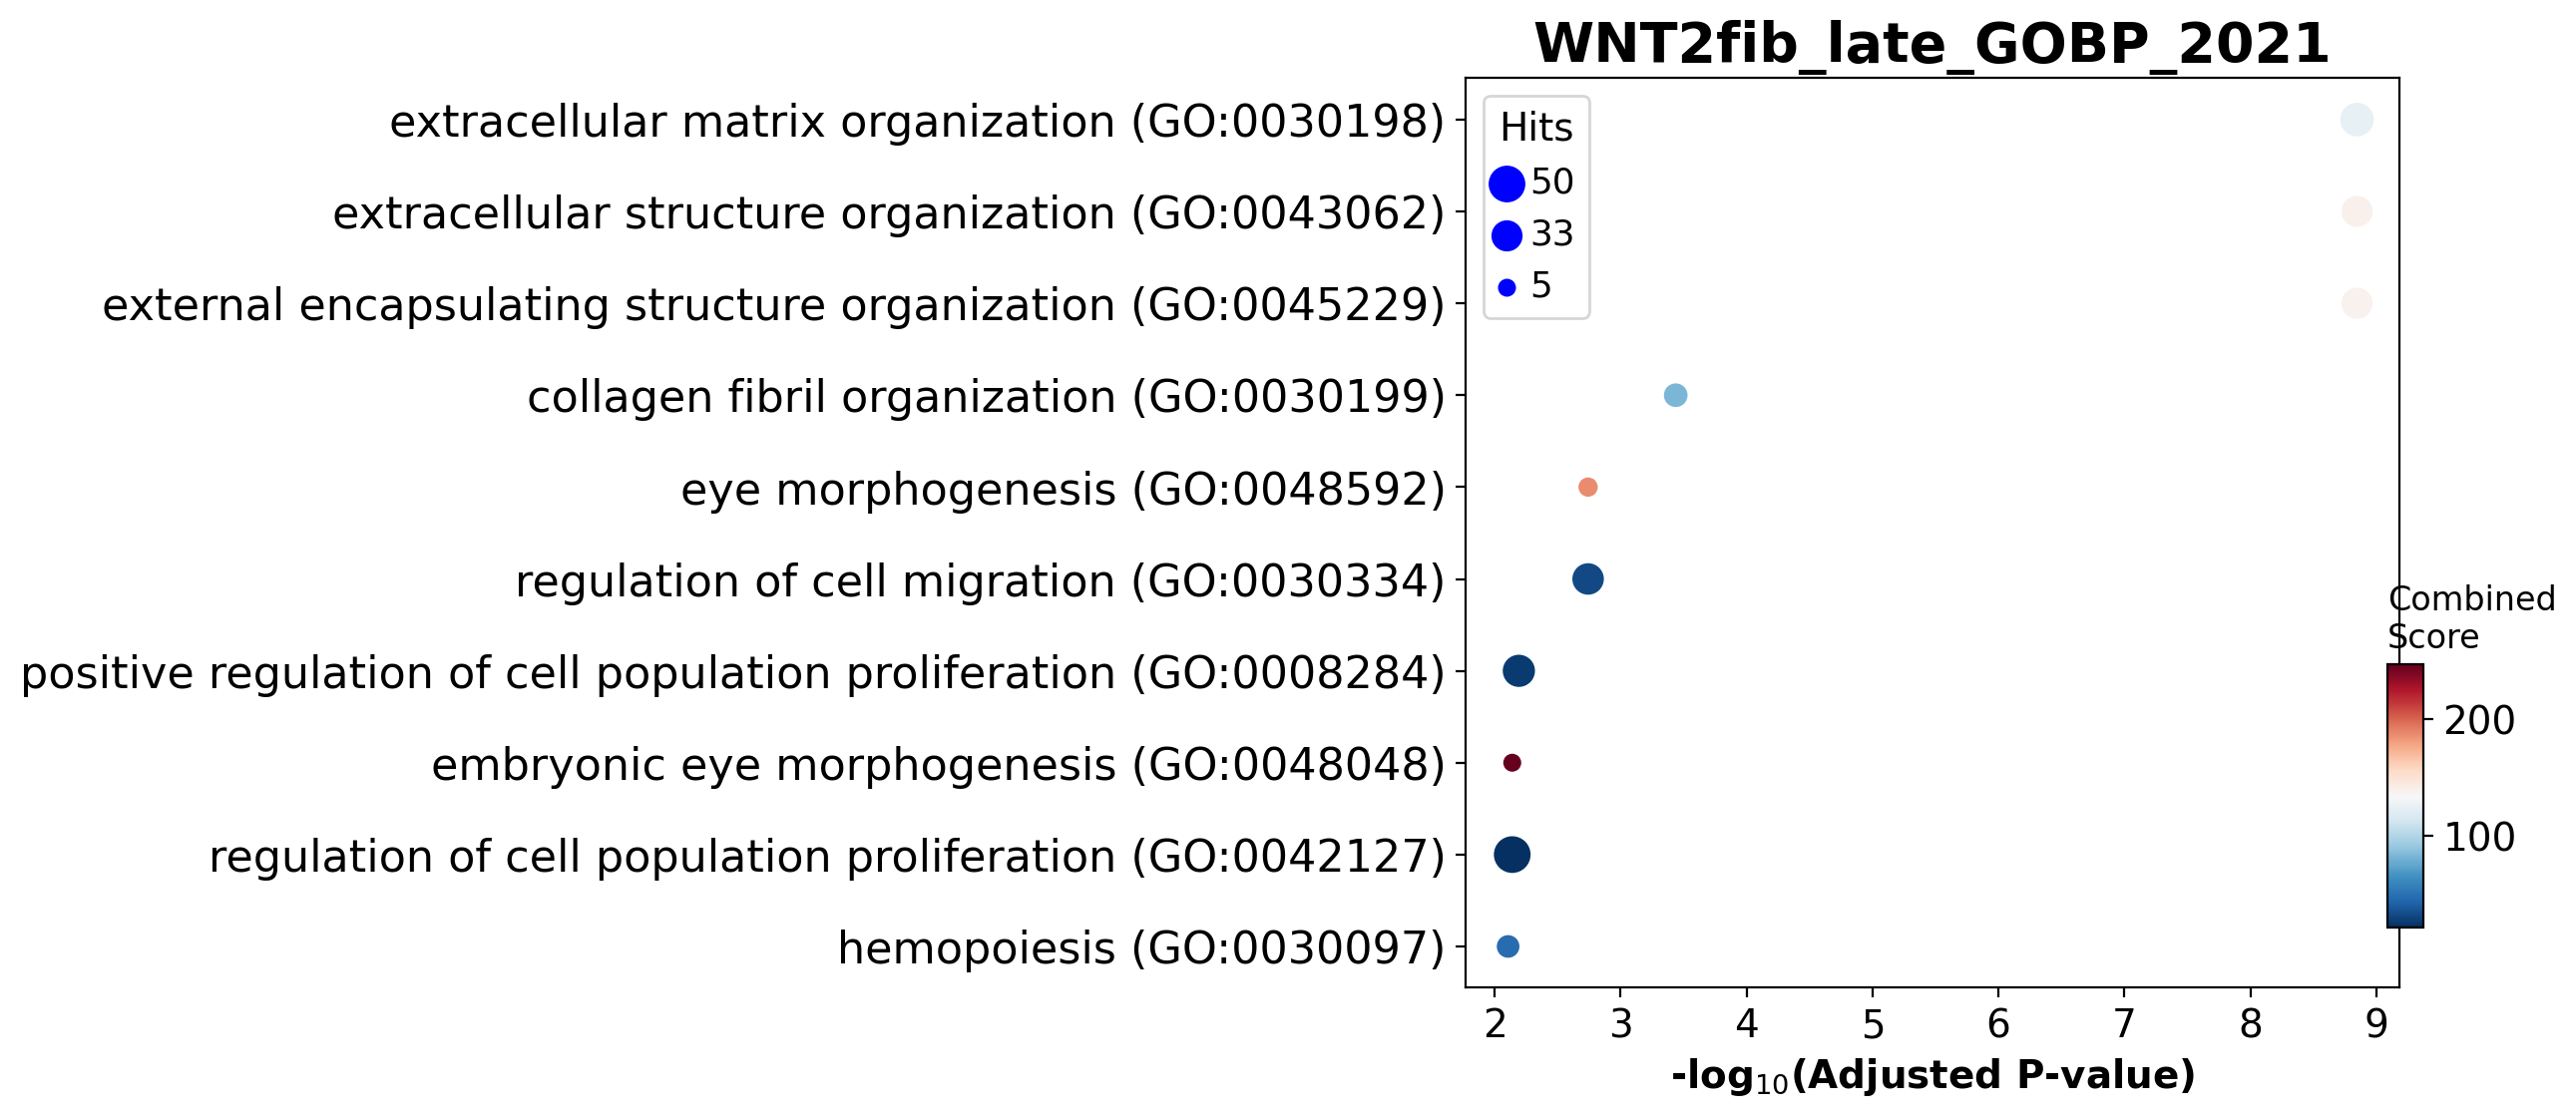

In [42]:
gp.dotplot(enr_WNT2fibearly.res2d,title='WNT2fib_early_GOBP_2021', top_term=10, figsize=(6,6))
gp.dotplot(enr_WNT2fiblate.res2d,title='WNT2fib_late_GOBP_2021',  top_term=10, figsize=(6,6))
#gp.dotplot(enr_WNT2fibearly.res2d,title='WNT2fib_early_GOBP_2021', top_term=10, figsize=(6,6), ofname='WNT2_early_GOBP_21052023.pdf')
##gp.dotplot(enr_WNT2fibearly_Hallmark.res2d,title='WNT2fib_early_MSigDB_Hallmark_2020',  top_term=10, cmap='viridis')
#gp.dotplot(enr_WNT2fiblate.res2d,title='WNT2fib_late_GOBP_2021',  top_term=10, figsize=(6,6), ofname='WNT2_late_210523.pdf')
##gp.dotplot(enr_WNT2fiblate_Hallmark.res2d,title='WNT2fib_late_MSigDB_Hallmark_2020',  top_term=10, cmap='viridis')

# Plot DEGs from early-late WNT2+ comparison by PCW

## Create object WNT2+ fibroblast only

In [47]:
#slice prenatal skin object to WNT2+ fibroblast only

WNT2_fib = ['WNT2+ fibroblast']
adata_WNT2 = adata[adata.obs['joint_annotation_20220202'].isin(WNT2_fib)]
adata_WNT2

View of AnnData object with n_obs × n_vars = 29109 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220

In [48]:
print(list(adata_WNT2.obs['pcw'].unique()))

[8, 9, 10, 7, 13, 16, 12, 15, 11, 14]


In [49]:
new_bins = {
'7' : '7-8',
'8' : '7-8',
'9' : '9-11',
'10' : '9-11',
'11' : '9-11',
'12' : '12-13',
'13' : '12-13',
'14' : '14-16',
'15' : '14-16',
'16' : '14-16'
}
new_bins

{'7': '7-8',
 '8': '7-8',
 '9': '9-11',
 '10': '9-11',
 '11': '9-11',
 '12': '12-13',
 '13': '12-13',
 '14': '14-16',
 '15': '14-16',
 '16': '14-16'}

In [50]:
adata_WNT2.obs['pcw_binned'] = adata_WNT2.obs['pcw'].astype(str).map(new_bins)
adata_WNT2.obs['pcw_binned'] = adata_WNT2.obs['pcw_binned'].astype('category')
adata_WNT2.obs['pcw_binned'].value_counts()

Trying to set attribute `.obs` of view, copying.


14-16    13369
9-11      6844
7-8       6067
12-13     2829
Name: pcw_binned, dtype: int64

In [51]:
adata_WNT2.obs['pcw_binned'] = adata_WNT2.obs['pcw_binned'].cat.reorder_categories([
'7-8',
'9-11',
'12-13',
'14-16'
])

In [53]:
print(list(adata_WNT2.obs['joint_annotation_20220202'].unique()))

['WNT2+ fibroblast']


## Plot matrix plot

In [54]:
#Based on DEGs and GSEApy analyses above - list of genes and corresponding functions selected

In [56]:
#Create dictionary
markers_WNT2_earlylate = {
 'Biosynthetic process and transcription' : ['EGR1', 'RDX', 'RPL23', 'SOX11', 'TWIST1'],
 'WNT signaling' : ['MDK', 'SFRP1', 'SFRP4', 'SOSTDC1', 'WIF1'],
 'Extracellular matrix organisation and collagen deposition' : ['ADAMTS5', 'ADAMTSL4', 'COL1A1', 'COL1A2', 'COL3A1', 'COL5A1', 'COL6A3', 'COL12A1', 'COL14A1', 'COL16A1',
                                                                'MFAP2', 'MFAP5', 'MMP14', 'POSTN', 'SPARC']}

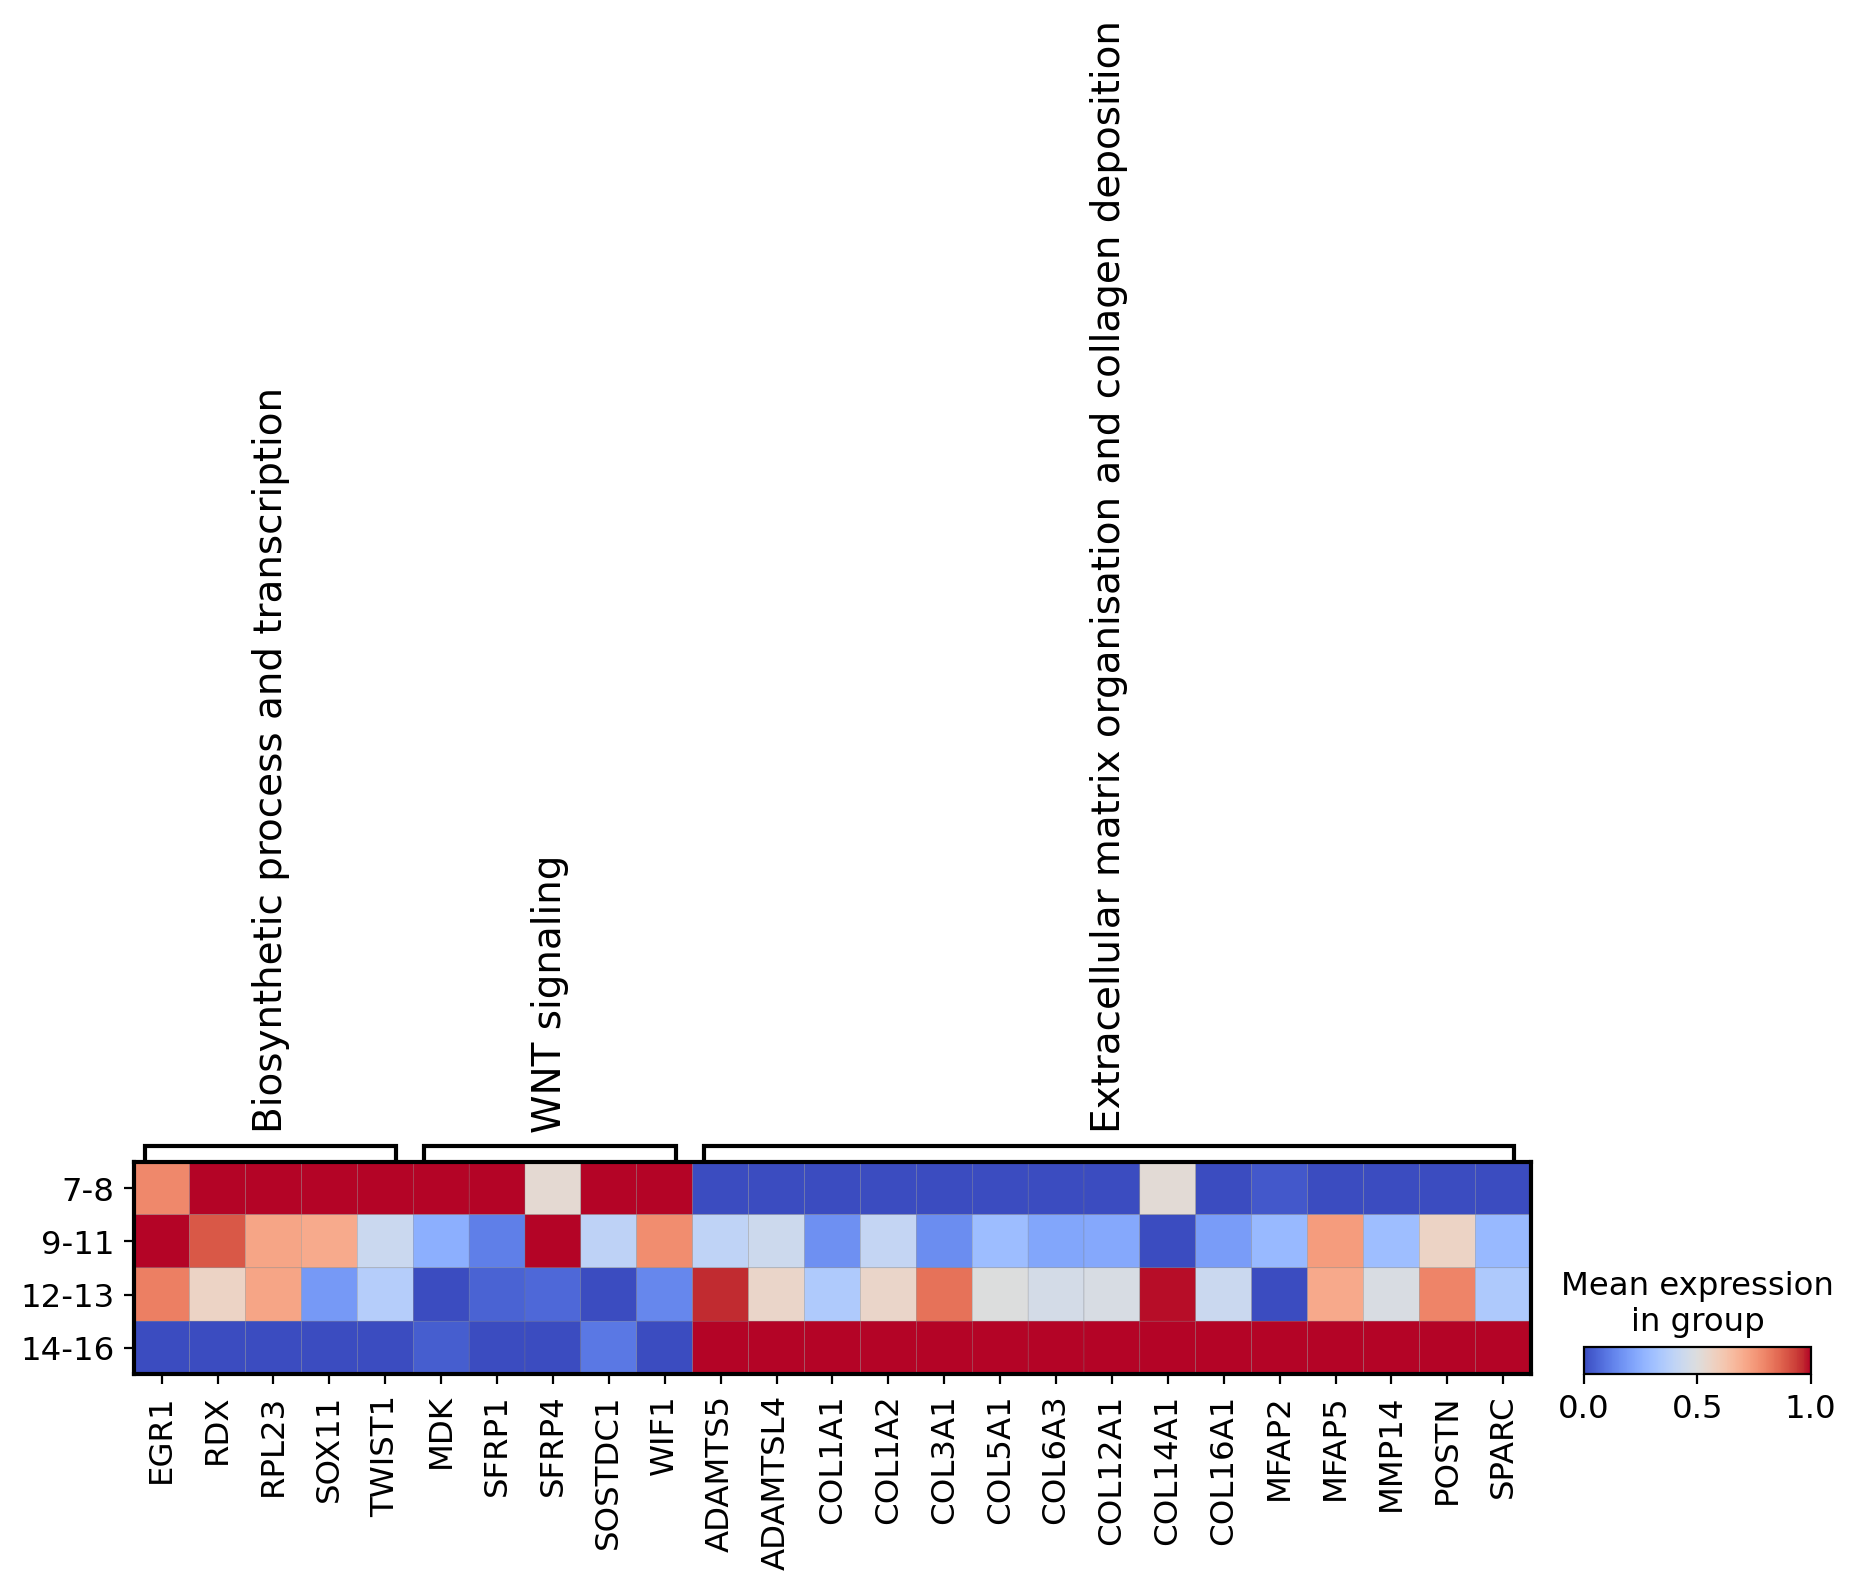

In [58]:
sc.pl.matrixplot(adata_WNT2, var_names=markers_WNT2_earlylate, groupby='pcw_binned', standard_scale='var', 
                 cmap='coolwarm')

#sc.pl.matrixplot(mdata_WNT2, var_names=markers_WNT2_earlylate, groupby='pcw_binned', standard_scale='var', 
#                 cmap='coolwarm', return_fig=True).savefig('/home/jovyan/projects/skin/fetal_skin/figures/marker_panels/figures_28042023/WNT2_comparison_groups_28042023.pdf')

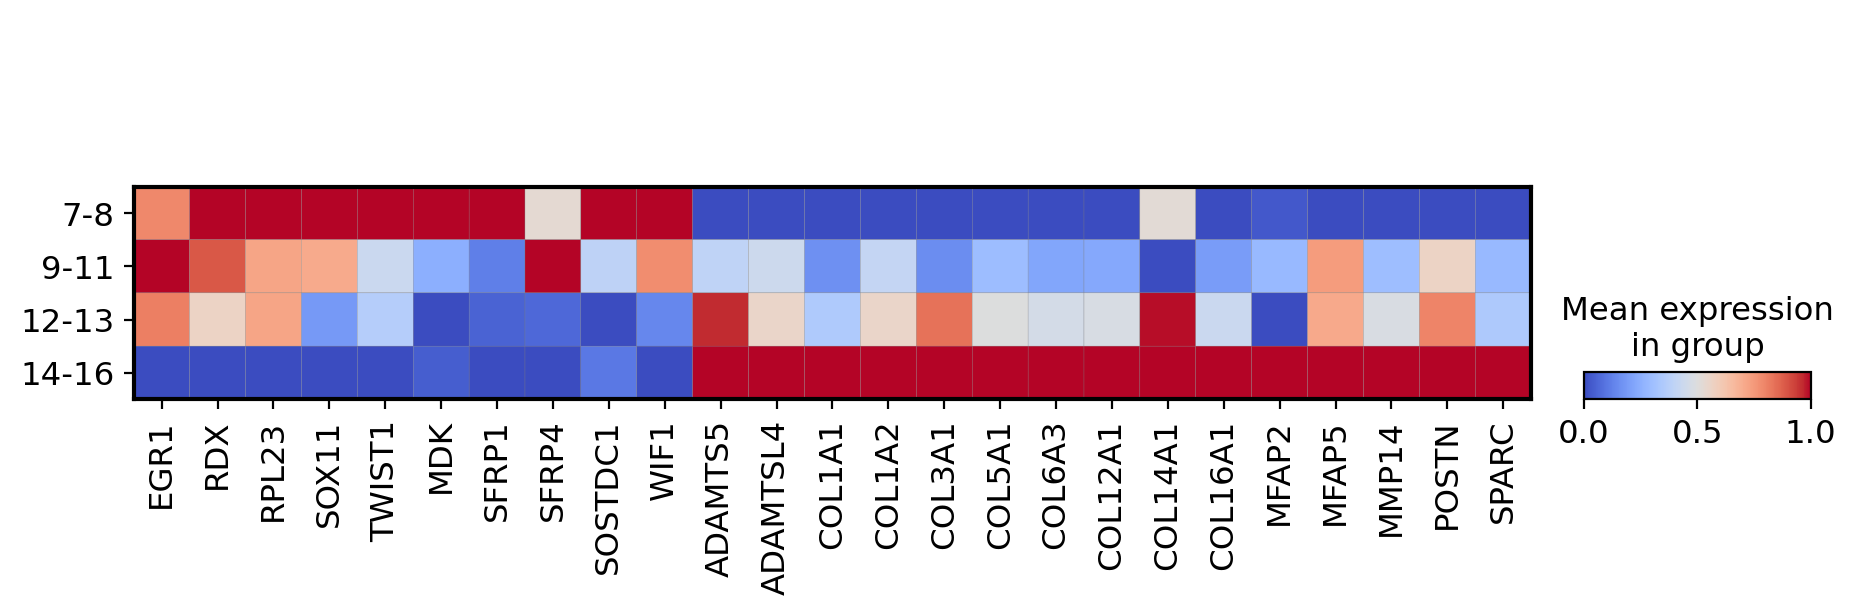

In [60]:
#plot same genes without functional annotations

sc.pl.matrixplot(adata_WNT2, var_names=['EGR1', 'RDX', 'RPL23', 'SOX11', 'TWIST1', 'MDK', 'SFRP1', 'SFRP4', 'SOSTDC1', 'WIF1', 
                           'ADAMTS5', 'ADAMTSL4', 'COL1A1', 'COL1A2', 'COL3A1', 'COL5A1', 'COL6A3', 'COL12A1', 'COL14A1', 'COL16A1',
                                        'MFAP2', 'MFAP5', 'MMP14', 'POSTN', 'SPARC'], groupby='pcw_binned', 
                 standard_scale='var', cmap='coolwarm')

#sc.pl.matrixplot(mdata_WNT2, var_names=['EGR1', 'RDX', 'RPL23', 'SOX11', 'TWIST1', 'MDK', 'SFRP1', 'SFRP4', 'SOSTDC1', 'WIF1', 
#                           'ADAMTS5', 'ADAMTSL4', 'COL1A1', 'COL1A2', 'COL3A1', 'COL5A1', 'COL6A3', 'COL12A1', 'COL14A1', 'COL16A1',
#                                        'MFAP2', 'MFAP5', 'MMP14', 'POSTN', 'SPARC'], groupby='pcw_binned', 
#                 standard_scale='var', cmap='coolwarm', return_fig=True).savefig('/home/jovyan/projects/skin/fetal_skin/figures/marker_panels/figures_28042023/WNT2_comparison_nogroups_28042023.pdf')